# Limit order book (LOB) simulation

**STILL TO DO**:
1. Power-law distributions look to occur on shorter return timescales and then on longer return timescales these move to Gaussian - look into whether this makes sense and then show what timescale this should occur over analytically if possible - probably something to do with the refresh rate vs independence assumption!
2. Looking for long-range memory in the temporal autocorrelation 
3. Show that in the quasi-stationary limit the queue lengths look something like $\sim \gamma^\lambda \lambda / (\gamma^\mu \mu + \nu)$ which should roughly look like a beta prime-distributed variable
4. Try to derive a theory for the time evolution of the mid price
5. Extended master equation to account for all of the above effects
6. A large-$N$ expansion and derive some jump-diffusion equations based on temporal scales

Using [Bouchaud et al. (2018)](https://doi.org/10.1017/9781316659335) as the main reference here.

The simulation of financial markets through the use of agent-based models is an increasingly popular technique to understand the microstructure of their dynamics from the bottom up. In this notebook, we'll look at an example market simulation.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Get the class structures
import sys
sys.path.append("/Users/Rob/work/finmarbs/utils/")
from lobsim import LOBsim
from sfagent import SFagentens
from reagent import reagentens

## A heterogeneous 'Santa Fe'-style model

Begin with a **heterogeneous individual-agent** version of the original **Santa Fe model** using a synchronous ensemble rejection algorithm. The key point here is to make sure the overall holding rate is large enough which should limit the number of anachronisms in the order flow...

In [64]:
setup = {
    # Number of agents
    "Nagents" : 50,
    # 1/variance in agent relative trading rates
    "heterok" : 0.1,
    # Mean global agent speculation refresh rate
    "meanspecrate" : 0.01,
    # Mean limit order rate per agent on the bid side
    "meanLOratebid" : 2.5,
    # Mean limit order rate per agent on the ask side
    "meanLOrateask" : 2.5,
    # Mean market order rate per agent on the bid side
    "meanMOratebid" : 2.0,
    # Mean market order rate per agent on the ask side
    "meanMOrateask" : 2.0,
    # Mean cancel order rate per agent on the bid side
    "meanCOratebid" : 1.1,
    # Mean cancel order rate per agent on the ask side
    "meanCOrateask" : 1.1,
    # The overall mean holding rate
    "meanHOrate" : 5.0,
    # Limit order decay power in price units
    "LOdecay" : 0.2,
    # Initial bid tick
    "initbidpricetick" : 498,
    # Initial ask tick
    "initaskpricetick" : 502,
    # The price tick size
    "tickscale" : 1.0,
    # The number of price points simulated
    "Nlattice" : 1000,
}

# Initialise the LOB simulation
los = LOBsim(setup, agentens=SFagentens)

# Iterate the LOB over time
tend, t = 3000.0, 0.0
midpssf = []
while t < tend:
    los.iterate()
    t = los.time
    midpssf.append([t, los.market_state_info["midprice"]])

# Create time series using the mid price output data
df_sf = pd.DataFrame(midpssf, columns=['Time', 'Mid price'])

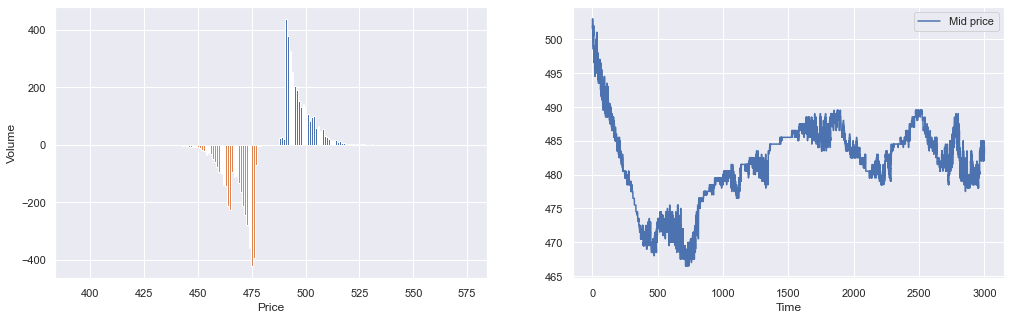

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].bar(los.prices, los.asks)
ax[0].bar(los.prices, -los.bids)
df_sf.set_index('Time').plot(ax=ax[1])
ax[0].set_xlim(
    [
        los.market_state_info["midprice"]-100.0,
        los.market_state_info["midprice"]+100.0,
    ]
)
ax[0].set_ylabel('Volume')
ax[0].set_xlabel('Price')
plt.show()

The master equation for the process above at price $p$ and $N$ agents is

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}P(\dots, V^p_{ib}, \dots, V^p_{ia}, \dots, t) &= \sum_{i=1}^N\gamma^\lambda_{ib}(t)\lambda^p_b(t) P(\dots, V^p_{ib}-1, \dots, V^p_{ia}, \dots, t) \\
&+ \sum_{i=1}^N\gamma^\lambda_{ia}(t)\lambda^p_a(t) P(\dots, V^p_{ib}, \dots, V^p_{ia}-1, \dots, t) \\
&+ \sum_{i=1}^N\frac{(V^p_{ib}+1)\sum_{i'=1}^N\gamma^\mu_{i'b}(t)\mu^p_{b}(t)}{1+\sum_{i'=1}^NV^p_{i'b}} P(\dots, V^p_{ib}+1, \dots, V^p_{ia}, \dots, t) \\
&+ \sum_{i=1}^N\frac{(V^p_{ia}+1)\sum_{i'=1}^N\gamma^\mu_{i'a}(t)\mu^p_{a}(t)}{1+\sum_{i'=1}^NV^p_{i'a}} P(\dots, V^p_{ib}, \dots, V^p_{ia}+1, \dots, t) \\
&+ \sum_{i=1}^N(V^p_{ib}+1)\nu_b P(\dots, V^p_{ib}+1, \dots, V^p_{ia}, \dots, t) \\
&+ \sum_{i=1}^N(V^p_{ia}+1)\nu_a P(\dots, V^p_{ib}, \dots, V^p_{ia}+1, \dots, t) \\
&- \sum_{i=1}^N
\bigg\{ \gamma^\lambda_{ib}(t)\lambda^p_b(t) + \gamma^\lambda_{ia}(t)\lambda^p_a(t) + \gamma^\mu_{ib}(t)\mu^p_{b}(t) + \gamma^\mu_{ia}(t)\mu^p_{a}(t) + V^p_{ib}\nu_b + V^p_{ia}\nu_a \bigg\} P(\dots, V^p_{ib}, \dots, V^p_{ia}, \dots, t)\,,
\end{align}
$$

where $m(t)=[b(t)+a(t)]/2$ is the mid price and the other functions are

$$
\begin{equation}
\lambda^p_b(t) = \lambda_b \mathbb{1}_{m(t)\geq p} e^{-\alpha [m(t)-p]}\,, \quad \lambda^p_a(t) = \lambda_a \mathbb{1}_{p\geq m(t)} e^{-\alpha [p-m(t)]}\,, \quad \mu^p_{b}(t) = \mu_{b}\mathbb{1}_{a(t)= p}\,, \quad \mu^p_{a}(t) = \mu_{a}\mathbb{1}_{b(t)= p} \,,
\end{equation}
$$

where: $\lambda_b\,, \lambda_a$ are the average limit order rates per agent; $\alpha$ is the limit order decay power; $\mu_b\,, \mu_a$ are the average market order rates per agent; $\nu_b\,, \nu_a$ are the average order-cancellation rates per agent; and $\gamma^\lambda_{ib}(t), \gamma^\lambda_{ia}(t), \gamma^\mu_{ib}(t), \gamma^\mu_{ib}(t)$ model the $i$-th agents' preferred relative trading rates, which we draw in each case from a unit-mean and $1/k$-variance gamma distribution, i.e., ${\rm PDF}(\gamma^x_{iy})={\rm Gamma}(\gamma^x_{iy};k,k)$ and refresh for each agent at a mean speculation rate of $r$. Note that we denote $\mathbb{1}_A$ as an indicator function which takes value unity when $A$ is true, else 0.

Let us now approximate the volume sums to be the time-dependent stochastic processes $F^p_{a}(t) \simeq \sum_{i'=1}^N V^p_{i'a}(t)$ and $F^p_{b}(t) \simeq \sum_{i'=1}^N V^p_{i'b}(t)$ which are uncorrelated to the $i$-th agent's actions. By then marginalising over the full master equation bid and ask volumes $\forall i'\neq i$, we can hence obtain an approximate equation for each individual agent

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}P(V^p_{ib}, V^p_{ia}, t) &\simeq \gamma^\lambda_{ib}(t)\lambda^p_b(t) P(V^p_{ib}-1, V^p_{ia}, t) + \gamma^\lambda_{ia}(t)\lambda^p_a(t) P(V^p_{ib}, V^p_{ia}-1, t) \\
&+ \frac{(V^p_{ib}+1)}{1 + F^p_{b}(t)}\sum^N_{i'=1}\gamma^\mu_{i'b}(t)\mu^p_{b}(t)P(V^p_{ib}+1, V^p_{ia}, t) + \frac{(V^p_{ia}+1)}{1+F^p_{a}(t)}\sum^N_{i'=1}\gamma^\mu_{i'a}(t)\mu^p_{a}(t)P(V^p_{ib}, V^p_{ia}+1, t) \\
&+ (V^p_{ib}+1)\nu_b P(V^p_{ib}+1, V^p_{ia}, t) + (V^p_{ia}+1)\nu_a P(V^p_{ib}, V^p_{ia}+1, t) \\
&- \bigg\{ \gamma^\lambda_{ib}(t)\lambda^p_b(t) + \gamma^\lambda_{ia}(t)\lambda^p_a(t) + \frac{V^p_{ib}}{F^p_{b}(t)}\sum^N_{i'=1}\gamma^\mu_{i'b}(t)\mu^p_{b}(t) + \frac{V^p_{ia}}{F^p_{a}(t)}\sum^N_{i'=1}\gamma^\mu_{i'a}(t)\mu^p_{a}(t) + V^p_{ib}\nu_b + V^p_{ia}\nu_a \bigg\} P(V^p_{ib}, V^p_{ia}, t)\,.
\end{align}
$$

Taking the first moments of this equation with respect to $V^p_{ia}$ and $V^p_{ib}$ in turn, we then obtain the probability mass function solution of two independent time-inhomogeneous Poisson processes

$$
\begin{align}
P(V^p_{ib}, V^p_{ia}, t) &\simeq {\rm Poisson}\big[ V^p_{ib};{\rm E}_{t}(V^p_{ib})\big] {\rm Poisson}\big[ V^p_{ia};{\rm E}_{t}(V^p_{ia})\big] \\
{\rm E}_{t}(V^p_{ib}) &\simeq {\rm E}_{t_0}(V^p_{ib})\exp \bigg\{ - \int_{t_0}^t \sum^N_{i'=1}\gamma^\mu_{i'b}(t')\frac{\mu^p_{b}(t')}{F^p_{b}(t')}{\rm d}t' - \nu_b(t-t_0)\bigg\} \\
&+  \int_{t_0}^t {\rm d}t' \gamma^\lambda_{ib}(t')\lambda^p_b(t') \exp \bigg\{ - \int_{t'}^t \sum^N_{i'=1}\gamma^\mu_{i'b}(t'')\frac{\mu^p_{b}(t'')}{F^p_{b}(t'')}{\rm d}t'' - \nu_b(t-t')\bigg\} \\
{\rm E}_{t}(V^p_{ia}) &\simeq {\rm E}_{t_0}(V^p_{ia})\exp \bigg\{ - \int_{t_0}^t  \sum^N_{i'=1}\gamma^\mu_{i'a}(t')\frac{\mu^p_{a}(t')}{F^p_{a}(t')}{\rm d}t' - \nu_a(t-t_0)\bigg\} \\
&+ \int_{t_0}^t {\rm d}t' \gamma^\lambda_{ia}(t')\lambda^p_a(t') \exp \bigg\{ - \int_{t'}^t  \sum^N_{i'=1}\gamma^\mu_{i'a}(t'')\frac{\mu^p_{a}(t'')}{F^p_{a}(t'')}{\rm d}t'' - \nu_a(t-t')\bigg\} \,.
\end{align}
$$

Note that by summing over $i$, we obtain an approximate description of the volume queue at each price $p$. Furthermore, we may infer that the probabilities for a price having non-zero bid or ask volume, respectively, at time $t$ are given by

$$
\begin{equation}
P\bigg( \sum_{i=1}^NV^p_{ib}>0, t\bigg) = 1-e^{-\sum_{i=1}^N{\rm E}_{t}(V^p_{ib})}\,, \qquad P\bigg( \sum_{i=1}^NV^p_{ia}>0, t\bigg) = 1-e^{-\sum_{i=1}^N{\rm E}_{t}(V^p_{ia})}\,.
\end{equation}
$$

Note also that as the distribution approaches stationarity, the distributions over the sum of agent volumes $\sum_{i=1}^NV^p_{ib}$ and $\sum_{i=1}^NV^p_{ia}$ for a given price are also approximately Poisson (since there is an overall cancellation of the gamma-distributed factor in the second integrals within the expressions above). 

**Potentially we can also approximate** $\sum_{i=1}^N{\rm d}V^p_{ib}(t) \simeq \big\{ \sum_{i=1}^N{\rm E}[V^p_{ib}(t)] - \sum_{i=1}^NV^p_{ib}(t)\big\} q{\rm d}t + \big\{ \sum_{i=1}^N{\rm Var}[V^p_{ib}(t)]\big\}^{1/2}q^{1/2}{\rm d}W(t)$ where $q$ is some mean-reversion rate to think about.

<ipython-input-69-f0566e09c916>:29: RuntimeWarning: divide by zero encountered in log
  np.log(fgau[::-1]),
<ipython-input-69-f0566e09c916>:36: RuntimeWarning: divide by zero encountered in log
  np.log(fsf[::-1]),
<ipython-input-69-f0566e09c916>:29: RuntimeWarning: divide by zero encountered in log
  np.log(fgau[::-1]),
<ipython-input-69-f0566e09c916>:36: RuntimeWarning: divide by zero encountered in log
  np.log(fsf[::-1]),
<ipython-input-69-f0566e09c916>:29: RuntimeWarning: divide by zero encountered in log
  np.log(fgau[::-1]),
<ipython-input-69-f0566e09c916>:36: RuntimeWarning: divide by zero encountered in log
  np.log(fsf[::-1]),
<ipython-input-69-f0566e09c916>:29: RuntimeWarning: divide by zero encountered in log
  np.log(fgau[::-1]),
<ipython-input-69-f0566e09c916>:36: RuntimeWarning: divide by zero encountered in log
  np.log(fsf[::-1]),
<ipython-input-69-f0566e09c916>:29: RuntimeWarning: divide by zero encountered in log
  np.log(fgau[::-1]),
<ipython-input-69-f0566e09c916>:

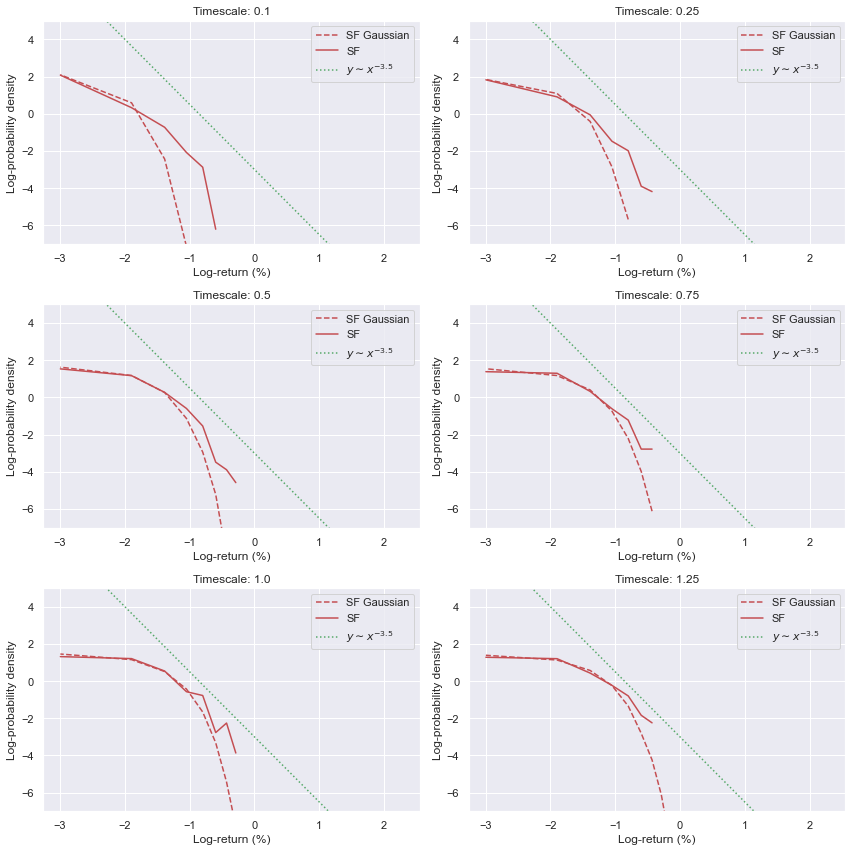

In [69]:
dts = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25] # Time periods 
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1], ax[2, 0], ax[2, 1]]
for dt, ax in zip(dts, axs):
    df_sf_asof = df_sf.set_index('Time').asof(
        np.arange(dt, 500.0, dt)
    ).iloc[20:]
    perc_returns_sf = 100.0 * (
        df_sf_asof.diff().shift(-1) / df_sf_asof
    ).iloc[:-1].values
    fgau, bgau = np.histogram(
        np.abs(
            np.random.normal(
                np.mean(perc_returns_sf),
                np.std(perc_returns_sf),
                size=50000,
            )
        ),  
        density=True,
        bins=np.arange(0.0, 10.0, 0.1)
    )
    fsf, bsf = np.histogram(
        np.abs(perc_returns_sf),  
        density=True,
        bins=np.arange(0.0, 10.0, 0.1)
    )
    ax.plot(
        np.log(0.5*(bgau[1:]+bgau[:-1])[::-1]), 
        np.log(fgau[::-1]),
        '--',
        color='r',
        label='SF Gaussian',
    )
    ax.plot(
        np.log(0.5*(bsf[1:]+bsf[:-1])[::-1]), 
        np.log(fsf[::-1]),
        color='r',
        label='SF',
    )
    ax.plot(
        np.log(0.5*(bsf[1:]+bsf[:-1])[::-1]),
        -3.5*np.log(0.5*(bsf[1:]+bsf[:-1])[::-1]) - 3.0,
        ':',
        color='g',
        label=r'$y\sim x^{-3.5}$',
    )
    ax.legend()
    ax.set_ylim([-7.0, 5.0])
    ax.set_ylabel('Log-probability density')
    ax.set_xlabel('Log-return (%)')
    ax.set_title('Timescale: ' + str(dt))
plt.tight_layout()
plt.show()

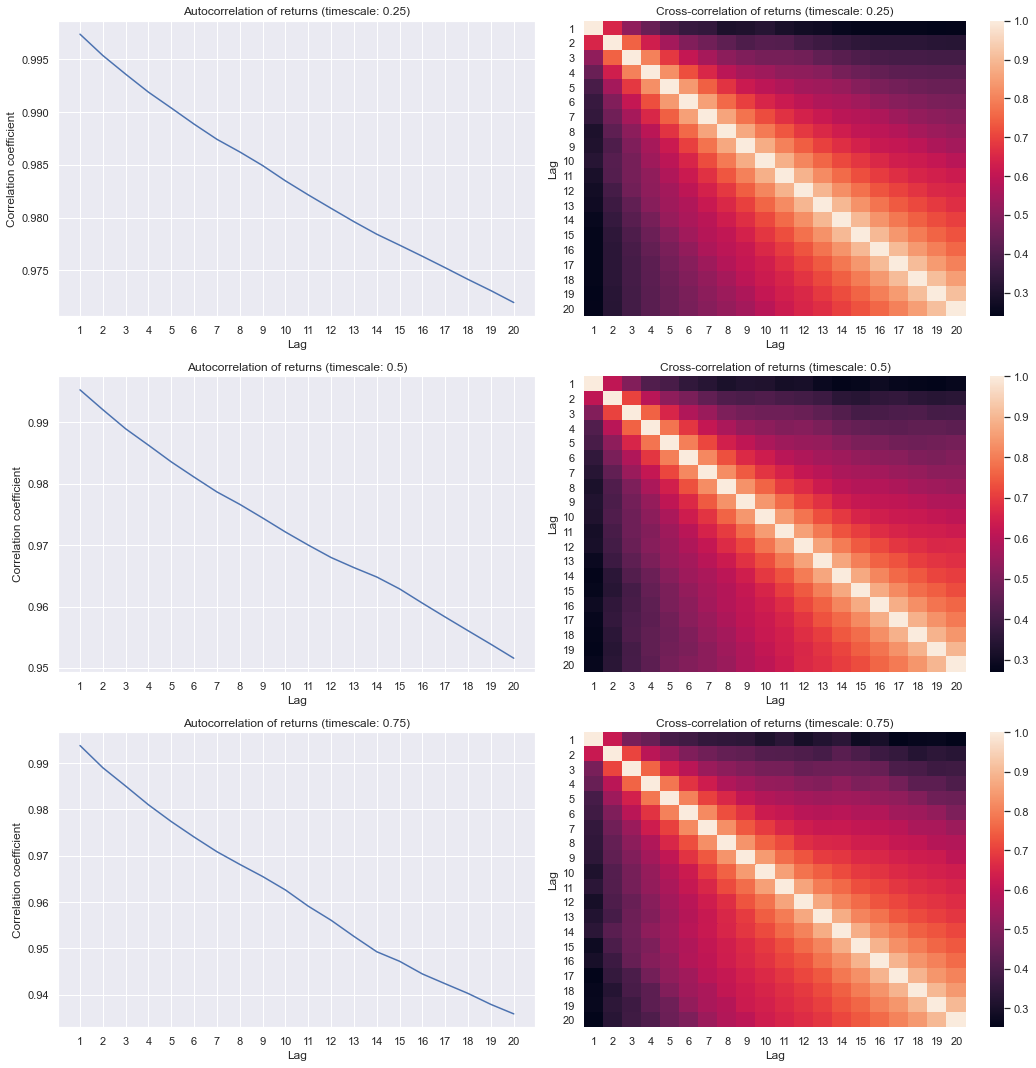

In [67]:
nlags = 20
dts = [0.25, 0.5, 0.75] # Time periods
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
axs = [ax[0], ax[1], ax[2]]
for dt, ax in zip(dts, axs):
    df_sf_asof = df_sf.set_index('Time').asof(
        np.arange(dt, 500.0, dt)
    )
    c = np.zeros(nlags)
    cc = np.zeros((nlags, nlags))
    for lag1 in range(1, nlags + 1):
        s1 = df_sf_asof - df_sf_asof.mean()
        s2 = df_sf_asof.shift(lag1) - df_sf_asof.mean()
        c[lag1-1] = (
            (s1 * s2).mean()
            / np.sqrt(
                (s1 * s1).mean() * (s2 * s2).mean()
            )
        )
        for lag2 in range(1, nlags + 1):
            maxlag = np.maximum(lag1, lag2)
            s1 = df_sf_asof - df_sf_asof.shift(lag1)
            s2 = df_sf_asof - df_sf_asof.shift(lag2)
            cc[lag1-1, lag2-1] = (
                (s1 * s2).mean()
                / np.sqrt(
                    (s1 * s1).mean() * (s2 * s2).mean()
                )
            )
    ax[0].plot(range(1, nlags + 1), c)
    sns.heatmap(cc, ax=ax[1])
    ax[0].set_xticks(range(1, nlags + 1))
    ax[1].set_xticklabels(range(1, nlags + 1))
    ax[1].set_yticklabels(range(1, nlags + 1))
    ax[0].set_xlabel('Lag')
    ax[0].set_ylabel('Correlation coefficient')
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('Lag')
    ax[0].set_title(
        'Autocorrelation of returns (timescale: ' + str(dt) + ')'
    )
    ax[1].set_title(
        'Cross-correlation of returns (timescale: ' + str(dt) + ')'
    )
plt.tight_layout()
plt.show()

## Adding reactionary trading agents into the 'Santa Fe'-style model

Adding reactionary agents who look at the historic order flows from the market and react accordingly at different rates. This should provide a mechanistic model for endogeneous market self-excitations to complement the exogeneous fluctuations modelled in the previous section.

Each reactionary agent is attributed a timescale $\beta_i$ of interest which is drawn from a gamma distribution such that

$$
\begin{equation}
{\rm PDF}(\beta_i)={\rm Gamma}[\beta_i;{\rm E}(\beta_i)^2/{\rm Var}(\beta_i),{\rm Var}(\beta_i)/{\rm E}(\beta_i)]\,.
\end{equation}
$$

This governs the temporal scale over which they view the historic order flows of the market. 


In [79]:
setup = {
    # Number of agents
    "Nagents" : 50,
    # 1/variance in agent relative trading rates
    "heterok" : 0.1,
    # Mean global agent speculation refresh rate
    "meanspecrate" : 0.05,
    # Mean limit order rate per agent on the bid side
    "meanLOratebid" : 2.5,
    # Mean limit order rate per agent on the ask side
    "meanLOrateask" : 2.5,
    # Mean market order rate per agent on the bid side
    "meanMOratebid" : 2.0,
    # Mean market order rate per agent on the ask side
    "meanMOrateask" : 2.0,
    # Mean cancel order rate per agent on the bid side
    "meanCOratebid" : 1.1,
    # Mean cancel order rate per agent on the ask side
    "meanCOrateask" : 1.1,
    # The overall mean holding rate
    "meanHOrate" : 5.0,
    # Limit order decay power in price units
    "LOdecay" : 0.2,
    # Initial bid tick
    "initbidpricetick" : 498,
    # Initial ask tick
    "initaskpricetick" : 502,
    # The price tick size
    "tickscale" : 1.0,
    # The number of price points simulated
    "Nlattice" : 1000,
    # Number of reactionary agents
    "Nreactagents" : 10,
    # The mean reaction rate of the reactionary agents
    "reactratesmean" : 1.5,
    # The variance in the reaction rate of the reactionary agents
    "reactratesvar" : 2.0,
    # The amplitude factor of the rate for each reactionary agent
    "reactamp" : 2.0,
}

# Initialise the LOB simulation
los = LOBsim(setup, agentens=reagentens)

# Iterate the LOB over time
tend, t = 3000.0, 0.0
midpsre = []
while t < tend:
    los.iterate()
    t = los.time
    midpsre.append([t, los.market_state_info["midprice"]])
    
# Create time series using the mid price output data
df_re = pd.DataFrame(midpsre, columns=['Time', 'Mid price'])

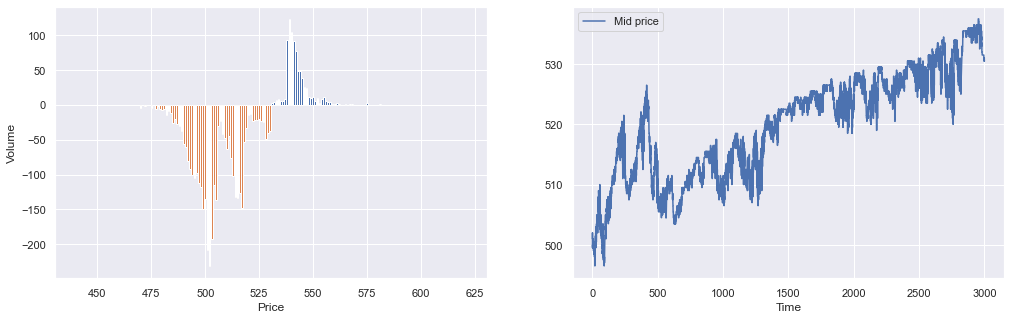

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].bar(los.prices, los.asks)
ax[0].bar(los.prices, -los.bids)
df_re.set_index('Time').plot(ax=ax[1])
ax[0].set_xlim(
    [
        los.market_state_info["midprice"]-100.0,
        los.market_state_info["midprice"]+100.0,
    ]
)
ax[0].set_ylabel('Volume')
ax[0].set_xlabel('Price')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
<ipython-input-84-d66d2e659bbb>:58: RuntimeWarning: divide by zero encountered in log
  np.log(fsf[::-1]),
<ipython-input-84-d66d2e659bbb>:71: RuntimeWarning: divide by zero encountered in log
  np.log(fre[::-1]),
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
<ipython-input-84-d66d2e659bbb>:58: RuntimeWarning: divide by zero encountered in log
  np.log(fsf[::-1]),
<ipython-input-84-d66d2e659bbb>:71: RuntimeWarning: divide by zero encountered in log
  np.log(fre[::-1]),
<ipython-input-84-d66d2e659bbb>:51: RuntimeWarning: divide by zero encountered in log
  np.log(fgausf[::-1]),
<ipython-input-84-d66d2e659bbb>:58: RuntimeWarning: divide by zero encountered in log
  np.log(fsf[::-1]),
<ipython-input-84-d66d2e659bbb>

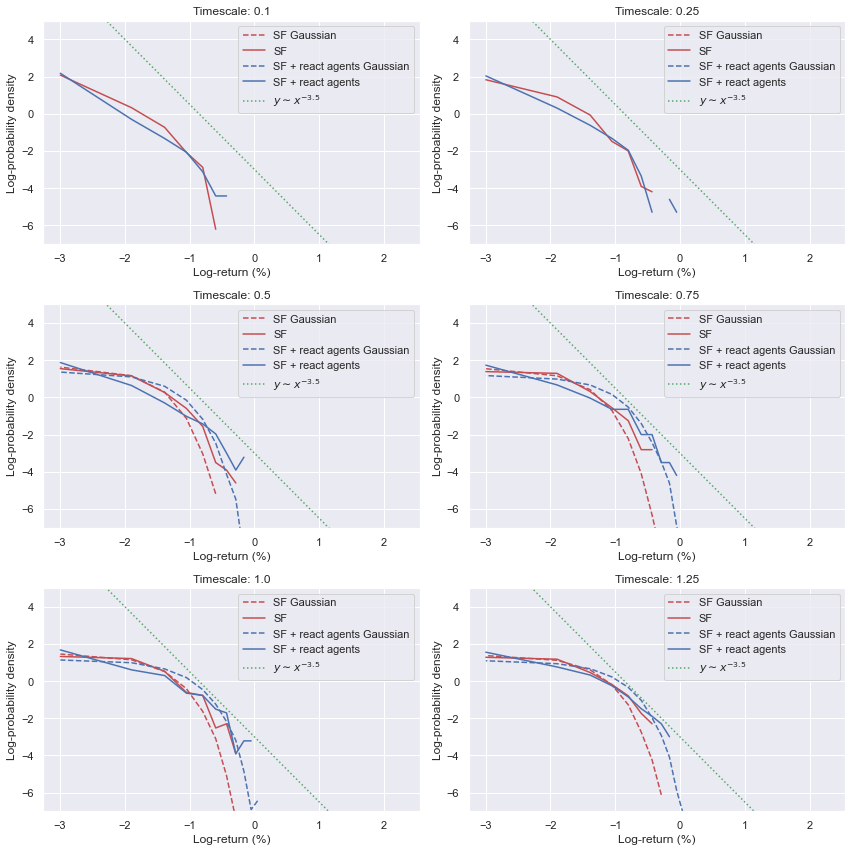

In [84]:
dts = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25] # Time periods 
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1], ax[2, 0], ax[2, 1]]
for dt, ax in zip(dts, axs):
    df_sf_asof = df_sf.set_index('Time').asof(
        np.arange(dt, 500.0, dt)
    )
    df_re_asof = df_re.set_index('Time').asof(
        np.arange(dt, 500.0, dt)
    )
    perc_returns_sf = 100.0 * (
        df_sf_asof.diff().shift(-1) / df_sf_asof
    ).iloc[:-1].values
    perc_returns_re = 100.0 * (
        df_re_asof.diff().shift(-1) / df_re_asof
    ).iloc[:-1].values
    fgausf, bgausf = np.histogram(
        np.abs(
            np.random.normal(
                np.mean(perc_returns_sf),
                np.std(perc_returns_sf),
                size=50000,
            )
        ),  
        density=True,
        bins=np.arange(0.0, 10.0, 0.1)
    )
    fgaure, bgaure = np.histogram(
        np.abs(
            np.random.normal(
                np.mean(perc_returns_re),
                np.std(perc_returns_re),
                size=50000,
            )
        ),  
        density=True,
        bins=np.arange(0.0, 10.0, 0.1)
    )
    fsf, bsf = np.histogram(
        np.abs(perc_returns_sf),  
        density=True,
        bins=np.arange(0.0, 10.0, 0.1)
    )
    fre, bre = np.histogram(
        np.abs(perc_returns_re),  
        density=True,
        bins=np.arange(0.0, 10.0, 0.1)
    )
    ax.plot(
        np.log(0.5*(bgausf[1:]+bgausf[:-1])[::-1]), 
        np.log(fgausf[::-1]),
        '--',
        color='r',
        label='SF Gaussian',
    )
    ax.plot(
        np.log(0.5*(bsf[1:]+bsf[:-1])[::-1]), 
        np.log(fsf[::-1]),
        color='r',
        label='SF',
    )
    ax.plot(
        np.log(0.5*(bgaure[1:]+bgaure[:-1])[::-1]), 
        np.log(fgaure[::-1]),
        '--',
        color='b',
        label='SF + react agents Gaussian',
    )
    ax.plot(
        np.log(0.5*(bre[1:]+bre[:-1])[::-1]), 
        np.log(fre[::-1]),
        color='b',
        label='SF + react agents',
    )
    ax.plot(
        np.log(0.5*(bsf[1:]+bsf[:-1])[::-1]),
        -3.5*np.log(0.5*(bsf[1:]+bsf[:-1])[::-1]) - 3.0,
        ':',
        color='g',
        label=r'$y\sim x^{-3.5}$',
    )
    ax.legend()
    ax.set_ylim([-7.0, 5.0])
    ax.set_ylabel('Log-probability density')
    ax.set_xlabel('Log-return (%)')
    ax.set_title('Timescale: ' + str(dt))
plt.tight_layout()
plt.show()

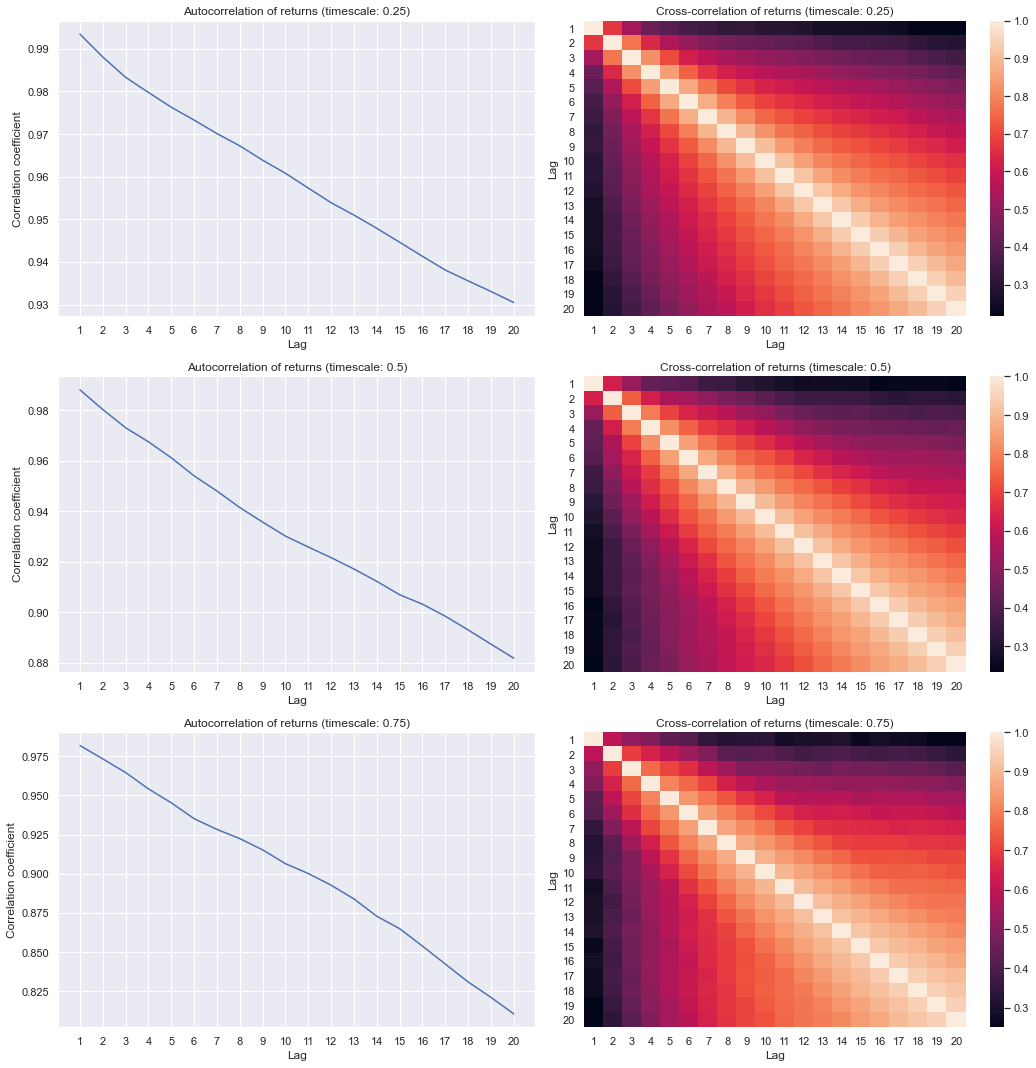

In [85]:
nlags = 20
dts = [0.25, 0.5, 0.75] # Time periods
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
axs = [ax[0], ax[1], ax[2]]
for dt, ax in zip(dts, axs):
    df_re_asof = df_re.set_index('Time').asof(
        np.arange(dt, 500.0, dt)
    )
    c = np.zeros(nlags)
    cc = np.zeros((nlags, nlags))
    for lag1 in range(1, nlags + 1):
        s1 = df_re_asof - df_re_asof.mean()
        s2 = df_re_asof.shift(lag1) - df_re_asof.mean()
        c[lag1-1] = (
            (s1 * s2).mean()
            / np.sqrt(
                (s1 * s1).mean() * (s2 * s2).mean()
            )
        )
        for lag2 in range(1, nlags + 1):
            maxlag = np.maximum(lag1, lag2)
            s1 = df_re_asof - df_re_asof.shift(lag1)
            s2 = df_re_asof - df_re_asof.shift(lag2)
            cc[lag1-1, lag2-1] = (
                (s1 * s2).mean()
                / np.sqrt(
                    (s1 * s1).mean() * (s2 * s2).mean()
                )
            )
    ax[0].plot(range(1, nlags + 1), c)
    sns.heatmap(cc, ax=ax[1])
    ax[0].set_xticks(range(1, nlags + 1))
    ax[1].set_xticklabels(range(1, nlags + 1))
    ax[1].set_yticklabels(range(1, nlags + 1))
    ax[0].set_xlabel('Lag')
    ax[0].set_ylabel('Correlation coefficient')
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('Lag')
    ax[0].set_title(
        'Autocorrelation of returns (timescale: ' + str(dt) + ')'
    )
    ax[1].set_title(
        'Cross-correlation of returns (timescale: ' + str(dt) + ')'
    )
plt.tight_layout()
plt.show()

## Bayesian analysis using a Hawkes process emulator of the market

Following the model structure ideas of [Blanc, Donier & Bouchaud (2015)](https://doi.org/10.1080/14697688.2016.1193215) design and build a Hawkes process emulator of the market dynamics above and use it to infer the process.

## Bayesian analysis using a geometric Brownian motion emulator of the market

Bayesian analysis and inference of the market using mock data generated with the simulator using a geometric Brownian motion model for the mid price only to mimic Black-Scholes risk calibration